<a href="https://colab.research.google.com/github/syq-tju/IL_AbRH/blob/main/Thermo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install numpy scipy matplotlib altair pandas


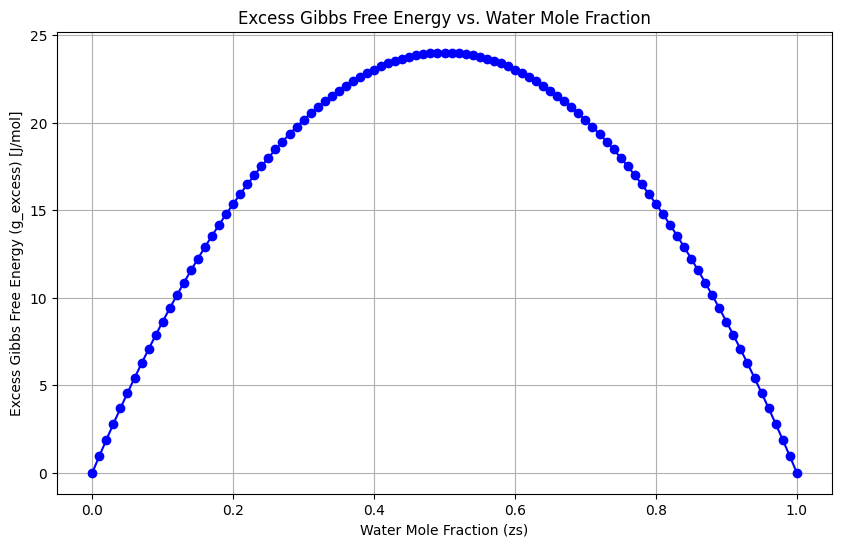

In [3]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd

# NRTL 参数 (水-乙醇体系)
tau_12 = 0.2936
tau_21 = 0.2936
G_12 = 164.96  # J/mol
G_21 = -69.57  # J/mol
alpha = 0.3  # Non-randomness parameter

R = 8.314  # J/(mol*K)  # 气体常数
T = 298.15  # K

def G_ij(T, G_ij):
    """Calculates G_ij at a given temperature."""
    return G_ij / (R * T)

def tau_ij(T, tau_ij):
    """Calculates tau_ij at a given temperature."""
    return tau_ij / (R * T)

def NRTL_gamma(x1, tau_12, tau_21, G_12, G_21, alpha):
    """Calculates activity coefficients using the NRTL model."""

    # Calculate G_ij and tau_ij at the given temperature
    G_12_calc = G_ij(T, G_12)
    G_21_calc = G_ij(T, G_21)
    tau_12_calc = tau_ij(T, tau_12)
    tau_21_calc = tau_ij(T, tau_21)

    # Helper functions for intermediate calculations
    def t_ij(tau_ij, G_ij):
        return np.exp(-alpha * tau_ij)

    def G_ji(G_ij):
        return G_ij / (R * T)

    # Calculate the non-randomness factors
    x2 = 1 - x1
    tau_12_final = tau_12_calc + (G_12_calc / (x1 + x2 * t_ij(tau_21_calc, G_21_calc)))
    tau_21_final = tau_21_calc + (G_21_calc / (x2 + x1 * t_ij(tau_12_calc, G_12_calc)))

    # Calculate the activity coefficients
    ln_gamma1 = x2**2 * (tau_21_final * (t_ij(tau_21_calc, G_21_calc) / (x1 + x2 * t_ij(tau_21_calc, G_21_calc)))**2
                        + tau_12_final * t_ij(tau_12_calc, G_12_calc) / (x2 + x1 * t_ij(tau_12_calc, G_12_calc))**2)
    ln_gamma2 = x1**2 * (tau_12_final * (t_ij(tau_12_calc, G_12_calc) / (x2 + x1 * t_ij(tau_12_calc, G_12_calc)))**2
                        + tau_21_final * t_ij(tau_21_calc, G_21_calc) / (x1 + x2 * t_ij(tau_21_calc, G_21_calc))**2)
    return np.exp(ln_gamma1), np.exp(ln_gamma2)

def excess_gibbs_free_energy(x1, tau_12, tau_21, G_12, G_21, alpha):
    """Calculates excess Gibbs free energy."""
    x2 = 1 - x1
    gamma1, gamma2 = NRTL_gamma(x1, tau_12, tau_21, G_12, G_21, alpha)
    return R * T * (x1 * np.log(gamma1) + x2 * np.log(gamma2))

# 创建 zs 值的列表 (从 0 到 1，步长为 0.01)
zs_water = np.linspace(0, 1, 101)

# 计算 g_excess 值
g_excess_values = [excess_gibbs_free_energy(x1, tau_12, tau_21, G_12, G_21, alpha) for x1 in zs_water]

# 绘制 g_excess 与 zs 的关系图 (使用 matplotlib)
plt.figure(figsize=(10, 6))
plt.plot(zs_water, g_excess_values, marker='o', linestyle='-', color='b')
plt.xlabel('Water Mole Fraction (zs)')
plt.ylabel('Excess Gibbs Free Energy (g_excess) [J/mol]')
plt.title('Excess Gibbs Free Energy vs. Water Mole Fraction')
plt.grid(True)
plt.show()

# 将数据转换为 DataFrame (确保在同一作用域内)
df = pd.DataFrame({'zs_water': zs_water, 'g_excess': g_excess_values})

# 创建图表 (使用 Altair)
chart = alt.Chart(df).mark_line(point=True).encode(
    x='zs_water',
    y='g_excess',
    tooltip = ['zs_water', 'g_excess']
).properties(
    title='Excess Gibbs Free Energy vs. Water Mole Fraction'
).interactive()

# 保存图表
chart.save('excess_gibbs_free_energy_vs_water_mole_fraction.json')
